In [59]:
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import gseapy as gp
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
from scipy import sparse

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

In [60]:
# Color
color_cts = clr.LinearSegmentedColormap.from_list("magma", ["#000003", "#3B0F6F", "#8C2980", "#F66E5B", "#FD9F6C", "#FBFCBF"], N=256)

In [61]:
# ==================== ssGSEA functions ==================== #

# Read GMT file into dict: {pathway: [genes]}
def read_gmt(gmt_path: str) -> dict:
    gene_sets = {}
    with open(gmt_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.rstrip("\n").split("\t")
            if len(parts) < 3:
                continue
            gs_name = parts[0]
            genes = [g for g in parts[2:] if g]
            gene_sets[gs_name] = genes
    return gene_sets

# Convert gseapy ssGSEA res (res.res2d, long format) to scores matrix (sample by pathway)
def res2d_to_scores(res, score_col = "NES"):
    
    df = res.res2d.copy()

    col_map = {c.lower(): c for c in df.columns}
    name_col = col_map.get("name", "Name")
    term_col = col_map.get("term", "Term")

    score_col_actual = None
    for c in df.columns:
        if c.upper() == score_col.upper():
            score_col_actual = c
            break
    if score_col_actual is None:
        raise ValueError(f"Score column {score_col} not found. Available: {list(df.columns)}")

    scores = df.pivot(index=name_col, columns=term_col, values=score_col_actual)
    scores.index.name = "cell_id"
    return scores

def ssGSEA_from_cellxgene_npz_filtered(
    npz_path: str,
    cell_ids: list,
    gene_ids: list,
    gmt_path: str,
    out_path: str,
    chunk_size: int = 2000,
    min_geneset_size: int = 5,
    max_geneset_size: int = 5000,
    do_log1p: bool = True,
    do_cpm: bool = True,
    min_total_counts: int = 5,      # SG library size threshold
    min_nnz_genes: int = 20,        # at least this many nonzero genes in SG vector
):
    # load cell by gene matrix
    X = sparse.load_npz(npz_path).tocsr()
    if X.shape != (len(cell_ids), len(gene_ids)):
        raise ValueError(f"Shape mismatch: X {X.shape} vs {(len(cell_ids), len(gene_ids))}")

    # parse GMT into dict: {pathway: [genes]}
    gene_sets = read_gmt(gmt_path)
    pathway_names = list(gene_sets.keys())

    # ---------
    # 1) Filter cells (SG-positive + enough genes)
    # ---------
    total_counts = np.asarray(X.sum(axis=1)).ravel()
    nnz_genes = np.diff(X.indptr)  # number of nonzero genes per row in CSR

    keep = (total_counts >= min_total_counts) & (nnz_genes >= min_nnz_genes)
    keep_idx = np.where(keep)[0]
    
    print(f"ssGSEA filtering: keeping {keep_idx.size} / {X.shape[0]} cells ({keep_idx.size / X.shape[0] * 100:.2f}%)")

    # Pre-allocate full scores (all cells) as zeros
    scores_full = pd.DataFrame(
        0.0,
        index=pd.Index(cell_ids, name="cell_id"),
        columns=pathway_names,
        dtype=np.float32,
    )

    # If nothing passes filtering, just write zeros and return
    if keep_idx.size == 0:
        scores_full.to_parquet(out_path)
        return scores_full

    # ---------
    # 2) Run ssGSEA on kept cells only (chunk over kept_idx)
    # ---------
    for start in range(0, keep_idx.size, chunk_size):
        end = min(start + chunk_size, keep_idx.size)
        idx = keep_idx[start:end]

        Xb = X[idx, :].astype(np.float32)

        # optional: CPM + log1p
        if do_cpm:
            libsize = np.asarray(Xb.sum(axis=1)).ravel()
            libsize[libsize == 0] = 1.0
            Xb = Xb.multiply(1e6 / libsize[:, None])
        if do_log1p:
            Xb = Xb.copy()
            Xb.data = np.log1p(Xb.data)

        # gseapy expects genes x samples DataFrame
        expr = pd.DataFrame(
            Xb.toarray().T,
            index=gene_ids,
            columns=[cell_ids[i] for i in idx],
        )

        res = gp.ssgsea(
            data=expr,
            gene_sets=gene_sets,
            sample_norm_method="rank",
            min_size=min_geneset_size,
            max_size=max_geneset_size,
            outdir=None,
            verbose=False,
            processes=1,
        )

        # sample x pathway
        scores = res2d_to_scores(res, score_col="NES")
        scores = scores.reindex(index=[cell_ids[i] for i in idx], columns=pathway_names)

        # write back into the full matrix (others stay 0)
        scores_full.loc[scores.index, scores.columns] = scores.astype(np.float32)

    scores_full.to_parquet(out_path)
    return scores_full

# # ssGSEA from cell by gene matrix (npz format)
# def ssGSEA_from_cellxgene_npz(npz_path: str, cell_ids: list, gene_ids: list, gmt_path: str, out_path: str, chunk_size: int = 2000, min_geneset_size: int = 5, max_geneset_size: int = 5000, do_log1p: bool = True, do_cpm: bool = True):
    
#     # load cell by gene matrix
#     X = sparse.load_npz(npz_path).tocsr()
#     if X.shape != (len(cell_ids), len(gene_ids)):
#         raise ValueError(f"Shape mismatch: X {X.shape} vs {(len(cell_ids), len(gene_ids))}")

#     # parse GMT into dict: {pathway: [genes]}
#     gene_sets = read_gmt(gmt_path)

#     all_scores = []

#     for start in range(0, X.shape[0], chunk_size):
        
#         end = min(start + chunk_size, X.shape[0])
#         Xb = X[start:end, :].astype(np.float32)

#         # optional: CPM + log1p to reduce ties (many zeros) and depth effects
#         if do_cpm:
#             libsize = np.asarray(Xb.sum(axis=1)).ravel()
#             libsize[libsize == 0] = 1.0
#             Xb = Xb.multiply(1e6 / libsize[:, None])
#         if do_log1p:
#             Xb = Xb.copy()
#             Xb.data = np.log1p(Xb.data)

#         # gseapy wants genes by samples (DataFrame)
#         expr = pd.DataFrame(
#             Xb.toarray().T,
#             index=gene_ids,
#             columns=cell_ids[start:end],
#         )

#         res = gp.ssgsea(
#             data=expr,
#             gene_sets=gene_sets,
#             sample_norm_method="rank",
#             min_size=min_geneset_size,
#             max_size=max_geneset_size,
#             outdir=None,
#             verbose=False,
#             processes=1,
#         )

#         # res.res2d: pathway by sample
#         scores = res2d_to_scores(res, score_col = "NES")
#         scores = scores.reindex(cell_ids[start:end])
#         all_scores.append(scores)
    
#     scores_df = pd.concat(all_scores, axis=0)
#     if not scores_df.index.is_unique:
#         raise ValueError("Duplicate cell IDs in final scores_df index.")

#     scores_df.to_parquet(out_path)
#     return scores_df

# def run_ssgsea_on_SG_only_with_filter(X_sg_npz_path: str, cell_ids: list, gene_ids: list, gmt_path: str, out_path: str, tmp_out_path: str, chunk_size: int = 2000,
#                                       min_total_counts: int = 1, min_nnz_genes: int = 20, min_geneset_size: int = 5, max_geneset_size: int = 5000, do_log1p: bool = True, do_cpm: bool = True):
    
#     # load SG-only matrix to decide which cells to keep
#     X = sparse.load_npz(X_sg_npz_path).tocsr()
#     if X.shape != (len(cell_ids), len(gene_ids)):
#         raise ValueError(f"Shape mismatch: X {X.shape} vs {(len(cell_ids), len(gene_ids))}")

#     total_counts = np.asarray(X.sum(axis=1)).ravel()
#     nnz_genes = np.diff(X.indptr)

#     keep = (total_counts >= min_total_counts) & (nnz_genes >= min_nnz_genes)
#     keep_idx = np.where(keep)[0]
#     keep_cell_ids = [cell_ids[i] for i in keep_idx]

#     # if nothing passes, output all-zeros
#     gene_sets = read_gmt(gmt_path)
#     pathways = list(gene_sets.keys())
#     scores_full = pd.DataFrame(0.0, index=pd.Index(cell_ids, name="cell_id"), columns=pathways, dtype=np.float32,)
#     if len(keep_cell_ids) == 0:
#         scores_full.to_parquet(out_path)
#         return scores_full, keep

#     # save a filtered NPZ (only kept cells) so your function can stay unchanged
#     X_keep = X[keep_idx, :]
#     sparse.save_npz(tmp_out_path, X_keep)

#     # Run your EXISTING function on kept cells only
#     scores_keep = ssGSEA_from_cellxgene_npz(
#         npz_path=tmp_out_path,
#         cell_ids=keep_cell_ids,
#         gene_ids=gene_ids,
#         gmt_path=gmt_path,
#         out_path=out_path + ".kept_only.parquet",
#         chunk_size=chunk_size,
#         min_geneset_size=min_geneset_size,
#         max_geneset_size=max_geneset_size,
#         do_log1p=do_log1p,
#         do_cpm=do_cpm,
#     )

#     # Fill back into the full matrix (others remain zero)
#     scores_full.loc[scores_keep.index, scores_keep.columns] = scores_keep.astype(np.float32)

#     # Write the final all-cells output
#     scores_full.to_parquet(out_path)

#     return scores_full, keep

In [62]:
data = "Xenium_5K_BC"
data_dir = f"../../data/{data}/"
utils_dir = "../../data/_utils/"
output_dir = f"../../output/{data}/"

In [63]:
# Read data
adata = sc.read_h5ad(data_dir + "intermediate_data/adata.h5ad")
adata_tumor = adata[adata.obs["cell_type_merged"] == "Malignant cell"].copy()
adata_tumor

AnnData object with n_obs × n_vars = 102180 × 5001
    obs: 'cell_id', 'global_x', 'global_y', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'cell_type', 'cell_type_merged'
    var: 'gene_ids', 'feature_types', 'genome', 'gene'
    uns: 'cell_type_colors', 'cell_type_merged_colors'

In [64]:
# Determine plot size
x_range = adata.obs["global_x"].max() - adata.obs["global_x"].min()
y_range = adata.obs["global_y"].max() - adata.obs["global_y"].min()
short_edge = min(x_range, y_range)

scale = 5 / short_edge
plot_figsize = (int(x_range * scale), int(y_range * scale))
print(f"Plot size: {plot_figsize}")
print("-" * 30)

Plot size: (5, 7)
------------------------------


In [65]:
plot_coords = ["global_x", "global_y"]

In [66]:
granule_adata = sc.read_h5ad(data_dir + "processed_data/granule_adata.h5ad")
granule_adata

AnnData object with n_obs × n_vars = 177704 × 5001
    obs: 'global_x', 'global_y', 'global_z', 'layer_z', 'sphere_r', 'size', 'comp', 'in_nucleus', 'gene', 'cell_id', 'nearest_cell_type', 'granule_id'
    var: 'genes'
    uns: 'nearest_cell_type_colors'

In [67]:
# Number of granules held by each cell
granule_counts = granule_adata.obs.groupby("cell_id").size()
adata_tumor.obs["granule_count"] = adata_tumor.obs["cell_id"].map(granule_counts).fillna(0).astype(int)
adata_tumor.obs["log_granule_count"] = np.log1p(adata_tumor.obs["granule_count"])

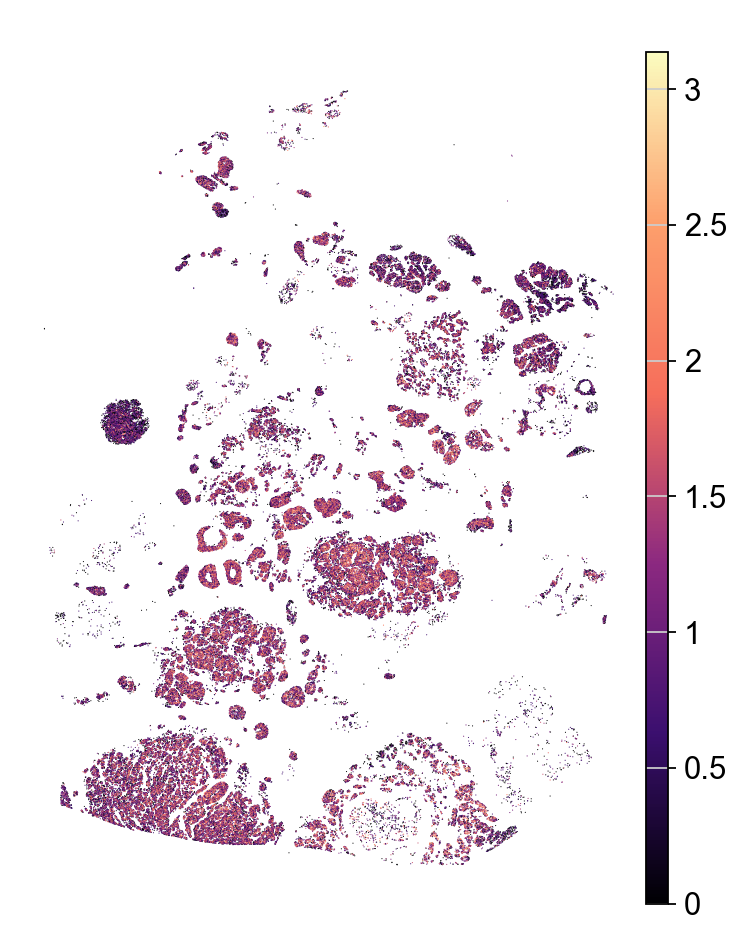

In [68]:
sc.set_figure_params(scanpy = True, figsize = plot_figsize)
ax = sc.pl.scatter(adata_tumor, alpha = 1, x = plot_coords[0], y = plot_coords[1], color = "log_granule_count", color_map = color_cts, size = 1, title = " ", show = False)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
for spine in ax.spines.values():
    spine.set_linewidth(False)
plt.show()

In [69]:
cell_ids = adata_tumor.obs["cell_id"].astype(str).to_numpy()
gene_ids = list(adata_tumor.var.index)

# Granule -> host cell mapping (one entry per granule obs)
granule_cell_ids = granule_adata.obs["cell_id"].astype(str).to_numpy()

# Map tumor cell_id -> row index
cell2row = {cid: i for i, cid in enumerate(cell_ids)}

# Row index in adata_tumor for each granule
rows = np.fromiter((cell2row.get(cid, -1) for cid in granule_cell_ids),
                   dtype=np.int64, count=len(granule_cell_ids))

# Keep only granules that successfully map to a tumor cell
keep = rows >= 0
rows = rows[keep]

In [70]:
Xg = granule_adata.X
if not sp.isspmatrix(Xg):
    Xg = sp.csr_matrix(Xg)
else:
    Xg = Xg.tocsr()
Xg = Xg[keep, :]

n_cells = adata_tumor.n_obs
n_granules = Xg.shape[0]

# Assignment matrix A: (cells x granules), one 1 per granule at its host cell row
A = sp.csr_matrix(
    (np.ones(n_granules, dtype=np.float32),
     (rows, np.arange(n_granules, dtype=np.int64))),
    shape=(n_cells, n_granules),
)

In [71]:
X_sg = (A @ Xg).tocsr()
sparse.save_npz(data_dir + "processed_data/SG_expression_matrix.npz", X_sg)
print(f"Shape of the SG expression matrix: {X_sg.shape}")

Shape of the SG expression matrix: (102180, 5001)


In [72]:
gmt_path = utils_dir + "hallmark_pathways_filtered.gmt"
sg_scores = ssGSEA_from_cellxgene_npz_filtered(
        npz_path = data_dir + "processed_data/nuclear_expression_matrix.npz",
        cell_ids = cell_ids,
        gene_ids = gene_ids,
        gmt_path = gmt_path,
        out_path = data_dir + "processed_data/ssgsea_hallmark_nuclear.parquet",
    )

ssGSEA filtering: keeping 93471 / 102180 cells (91.48%)


In [50]:
sg_scores

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaaaohf-1,-0.143212,-0.215667,0.070658,0.105858,-0.039188,-0.144355,-0.128151,-0.367519,-0.161682,0.008558,...,-0.257752,0.058217,-0.168299,0.093935,0.049705,-0.021131,-0.013819,-0.087471,-0.008749,-0.202920
aaaabkoj-1,-0.014046,-0.243530,0.075313,0.134084,-0.048073,-0.023099,-0.071909,-0.279286,-0.032129,-0.013929,...,-0.096915,0.220716,-0.254819,0.197619,0.010053,-0.049887,0.017346,-0.076695,-0.014993,-0.116312
aaaafefl-1,-0.136048,-0.203898,0.032252,0.137316,-0.043038,-0.154727,-0.141569,-0.324420,-0.069900,-0.015199,...,-0.213966,0.030157,-0.199958,0.057022,-0.016195,0.036713,-0.003516,-0.120282,-0.011774,-0.167251
aaaahfjm-1,-0.111967,-0.188796,0.169349,0.114447,-0.046021,-0.036923,-0.087291,-0.279061,0.113136,-0.042435,...,-0.072726,0.117092,-0.262168,0.155842,0.040569,-0.104641,0.075292,-0.026811,-0.066550,-0.218584
aaaahjao-1,-0.135786,-0.157579,0.098771,0.112246,-0.087486,-0.069077,-0.165345,-0.383537,-0.174212,-0.043729,...,-0.193905,0.004000,-0.250268,0.141022,0.036484,-0.038571,0.021675,-0.085131,-0.044396,-0.225543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ogicnekl-1,-0.080468,-0.209672,0.013303,0.029920,-0.061258,-0.099991,-0.185607,-0.400292,0.035534,-0.004320,...,-0.140176,0.002565,-0.195816,0.134895,0.028849,0.177110,-0.015915,-0.166603,0.060234,-0.232673
ognonagn-1,-0.122221,-0.212964,0.062551,0.033676,-0.041736,-0.191724,-0.202064,-0.350338,-0.113356,0.024860,...,-0.243111,0.052692,-0.246221,0.148993,-0.001876,-0.013098,-0.002622,-0.088401,0.023314,-0.173901
ogpdggle-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


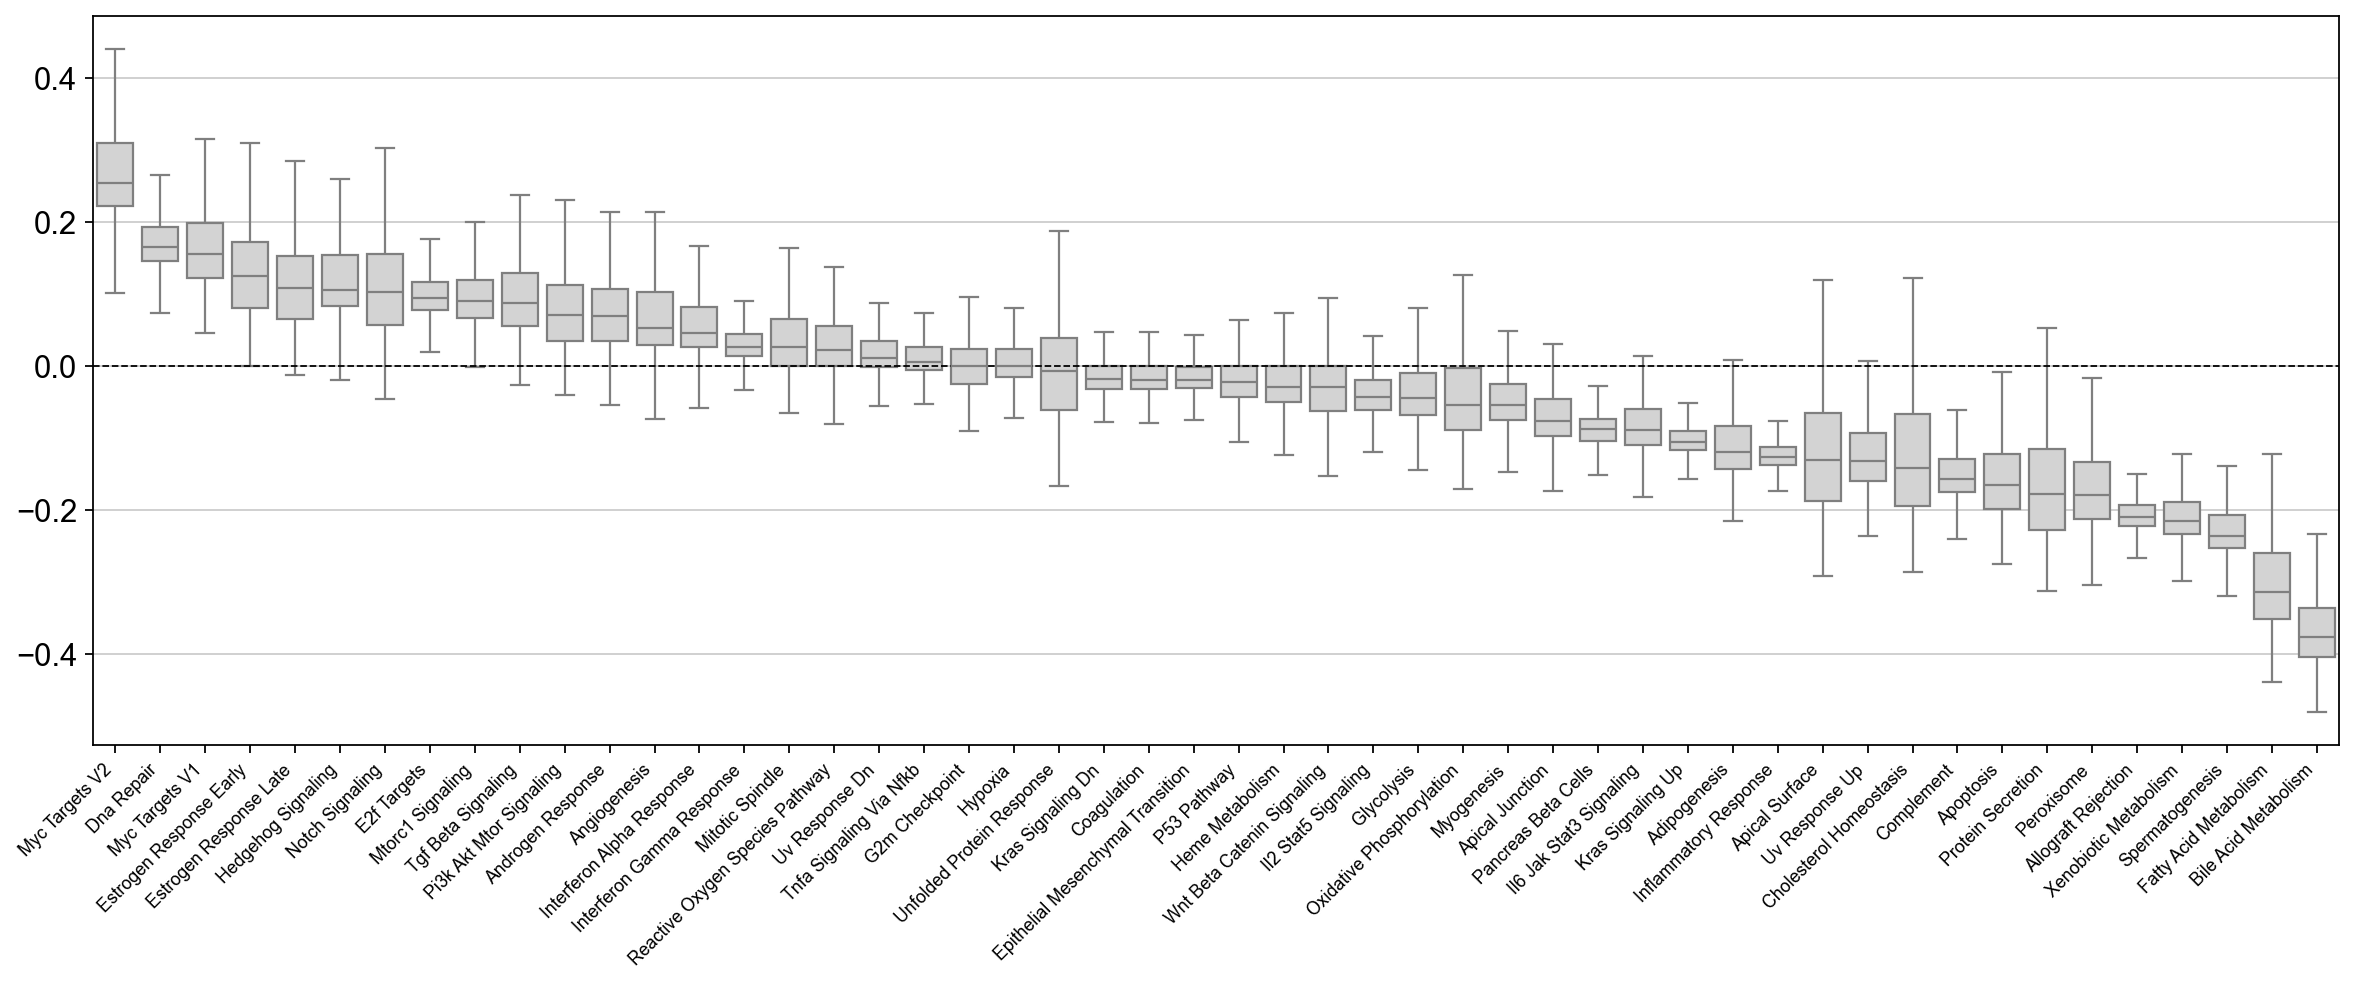

In [ ]:
scores_long = sg_scores.reset_index().melt(id_vars="cell_id", var_name="Pathway", value_name="NES")
order = scores_long.groupby("Pathway")["NES"].median().sort_values(ascending=False).index
order_labels = [" ".join(s.capitalize() for s in i.split("_")[1:]) for i in order]
plt.figure(figsize=(15, 6))
ax = sns.boxplot(data=scores_long, x="Pathway", y="NES", order=order, showfliers=False, color="lightgray")
ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax.set_xticklabels(order_labels, rotation=45, ha="right", fontsize=8)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

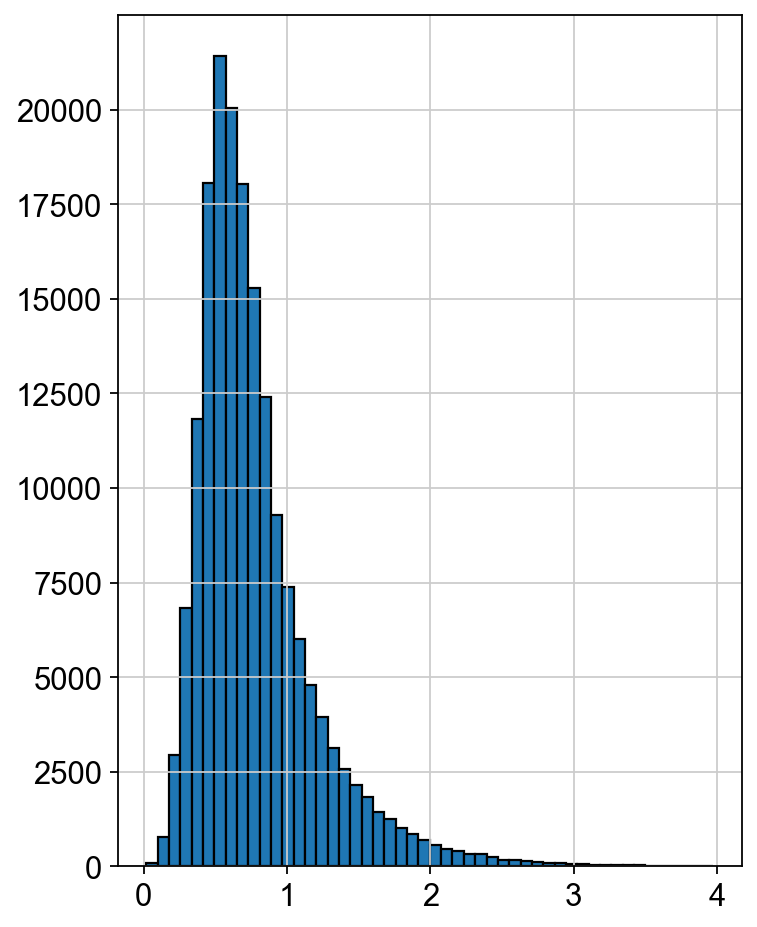

In [58]:
plt.hist(granule_adata.obs["sphere_r"], bins=50, edgecolor='black')
plt.show()

In [68]:
# ==================== Main operations ==================== #

settings = {"Xenium_5K_BC": {"cell_type_label": True},
            "Xenium_5K_OC": {"cell_type_label": True},
            "Xenium_5K_CC": {"cell_type_label": True},
            "Xenium_5K_LC": {"cell_type_label": False},
            "Xenium_5K_Prostate": {"cell_type_label": False},
            "Xenium_5K_Skin": {"cell_type_label": False}}

for data in settings.keys():
    
    print(f"========== Processing {data}... ==========")
    
    # paths
    data_dir = f"../../data/{data}/"
    utils_dir = "../../data/_utils/"
    output_dir = f"../../output/{data}/"
    
    # Read data
    adata = sc.read_h5ad(data_dir + "intermediate_data/adata.h5ad")
    adata_tumor = adata[adata.obs["cell_type_merged"] == "Malignant cell"].copy()
    
    # Determine plot size
    x_range = adata.obs["global_x"].max() - adata.obs["global_x"].min()
    y_range = adata.obs["global_y"].max() - adata.obs["global_y"].min()
    short_edge = min(x_range, y_range)

    scale = 5 / short_edge
    plot_figsize = (int(x_range * scale), int(y_range * scale))
    print(f"Plot size: {plot_figsize}")
    
    # check cell and gene IDs
    cell_ids = list(adata_tumor.obs["cell_id"])
    gene_ids = list(adata_tumor.var.index)
    
    cell_ids_npz = np.load(data_dir + "processed_data/cell_ids.npy", allow_pickle = True).tolist()
    gene_ids_npz = np.load(data_dir + "processed_data/gene_ids.npy", allow_pickle = True).tolist()
    
    if cell_ids_npz != cell_ids:
        raise ValueError("Cell ID order mismatch between NPZ and current adata_tumor!")

    if gene_ids_npz != gene_ids:
        raise ValueError("Gene order mismatch between NPZ and current adata_tumor!")
    
    # run ssGSEA in nuclear and cytoplasmic
    gmt_path = utils_dir + "hallmark_pathways.gmt"
    
    nuc_scores = ssGSEA_from_cellxgene_npz(
        npz_path = data_dir + "processed_data/nuclear_expression_matrix.npz",
        cell_ids = cell_ids,
        gene_ids = gene_ids,
        gmt_path = gmt_path,
        out_path = data_dir + "processed_data/ssgsea_hallmark_nuclear.parquet",
    )

    cyto_scores = ssGSEA_from_cellxgene_npz(
        npz_path = data_dir + "processed_data/cytoplasmic_expression_matrix.npz",
        cell_ids = cell_ids,
        gene_ids = gene_ids,
        gmt_path = gmt_path,
        out_path = data_dir + "processed_data/ssgsea_hallmark_cytoplasmic.parquet",
    )
    
    # pathway score box plots
    for scores, label in zip([nuc_scores, cyto_scores], ["Nuclear", "Cytoplasmic"]):
        scores_long = scores.reset_index().melt(id_vars="cell_id", var_name="Pathway", value_name="NES")
        order = scores_long.groupby("Pathway")["NES"].median().sort_values(ascending=False).index
        order_labels = [" ".join(s.capitalize() for s in i.split("_")[1:]) for i in order]
        plt.figure(figsize=(18, 6))
        ax = sns.boxplot(data=scores_long, x="Pathway", y="NES", order=order, showfliers=False, color="lightgray")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
        ax.set_xticklabels(order_labels, rotation=45, ha="right", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.savefig(output_dir + f"ssgsea_hallmark_{label.lower()}.jpeg", dpi = 300, bbox_inches = "tight")
        plt.close()
    
    # top pathways
    n_top = 5

    nuc_scores_mean = nuc_scores.mean(axis = 0).sort_values(ascending = False)
    top_nuc = nuc_scores_mean.head(n_top)
    
    cyto_scores_mean = cyto_scores.mean(axis = 0).sort_values(ascending = False)
    top_cyto = cyto_scores_mean.head(n_top)
    
    for pathway in top_nuc.index:
        
        # add pathway to adata_tumor.obs
        pathway_label = f"ssgsea_nuc_{pathway}"
        adata_tumor.obs[pathway_label] = nuc_scores[pathway].values
        
        # plot pathway score
        sc.set_figure_params(figsize = plot_figsize)
        ax = sc.pl.scatter(adata_tumor, x="global_x", y="global_y", color=pathway_label, color_map=color_cts, size=1, show=False)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.savefig(output_dir + f"{pathway_label}.jpeg", dpi = 300, bbox_inches = "tight")
        plt.close()
    
    for pathway in top_cyto.index:
        
        # add pathway to adata_tumor.obs
        pathway_label = f"ssgsea_cyto_{pathway}"
        adata_tumor.obs[pathway_label] = cyto_scores[pathway].values
        
        # plot pathway score
        sc.set_figure_params(figsize = plot_figsize)
        ax = sc.pl.scatter(adata_tumor, x="global_x", y="global_y", color=pathway_label, color_map=color_cts, size=1, show=False)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")
        for spine in ax.spines.values():
            spine.set_visible(False)
        plt.savefig(output_dir + f"{pathway_label}.jpeg", dpi = 300, bbox_inches = "tight")
        plt.close()

========== Processing Xenium_5K_BC... ==========
Plot size: (5, 7)
========== Processing Xenium_5K_OC... ==========
Plot size: (7, 5)
========== Processing Xenium_5K_CC... ==========
Plot size: (5, 5)
========== Processing Xenium_5K_LC... ==========
Plot size: (7, 5)
========== Processing Xenium_5K_Prostate... ==========
Plot size: (8, 5)
========== Processing Xenium_5K_Skin... ==========
Plot size: (10, 5)
